This notebook gives simple and fast computable example of our work. We will consider two evolutionary optimization procceses with a very small population size so that this example is accessible to any computational capacity. This quick introduction takes about 40 minutes to run (if you don't meet any issues with tensorflow -_-)

## Let's start!

In [1]:
#Import the required libraries
import numpy as np
import pickle
import matplotlib

"""
We need to import domain settings contained in constraints, our optimizer,
objective functions, surrogate and real models.
Also, we will add visualization.

"""
import constraints
from spea2 import SPEA2_optimizer
from models.get_models import Surrogate, RealModel
from models.surrogate_models import deep_conv_net, assistant_net
from objectives import cost, wave_h
from visualization import plot_map

C:\Users\jkee2\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.72588e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,


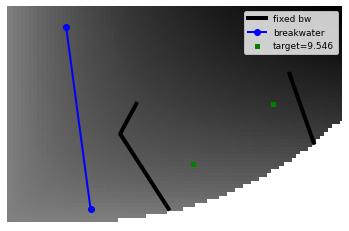

In [2]:
"""
Thats our domain settings,
x - width of acquatory
y - length of acquatory
Z - bathymetry
"""

x = constraints.x
y = constraints.y
X, Y = np.meshgrid(x, y)
Z = constraints.Z

"""
Let's visualize our problem, for this we will create a random configuration of breakwaters, 
they will be located with existing breakwaters
"""
%matplotlib inline
plot_map(X, Y, Z, np.random.randint(low = np.min(Y),
                                    high = np.max(Y),
                                    size = (1,4)))

In [3]:
"""
We need to define objectives functions and optimizer with appropriate inputs.
Our inputs set very small population, we establish only 5 individuals for population and 2 for archive, 
this makes our simple example not time-consuming. 

"""
func_to_optimize = [cost, wave_h]
spea2 = SPEA2_optimizer(pop_size=5,
                        arch_size=2,
                        max_iter=3,
                        mutat_rate_pop=0.35,
                        mutat_rate_individ=1.0,
                        domain=[[0, 2075],  # x-axis
                                [0, 1450]],  # y-axis
                        )

Let's start with optimization that consist of first and third block of our proposed approach, that is, without exploration phase (in paper it is called baseline). 
<br> In this case we will not use a surrogate.

In [4]:
#We create an instance of the class RealModel
real = RealModel()

"""
Now we call the optimize process with real model only and without exploration phase (exploration_phase=False).
As stop criteria we set maximum number of appeals to the real model (in this case - 10, for fast calculation).
As a surrogate, we specify a simple object with one state - False, which means no preparation to work.
After running this script history_baseline variable will have all information about optimization process 
(hypervolume behavior, archive population and approximation of pareto front at every iteration)

Note that, this script takes about 17 minutes on a PC with 8 cores.
"""
from types import SimpleNamespace
history_baseline = spea2.optimize(func_to_optimize = func_to_optimize,
                                  max_real_num_call = 15,
                                  surr = SimpleNamespace(**{'state': False}),
                                  real = real,
                                  exploration_phase=False)
                        

Swan calc = 5
ITER = 0
Swan calc = 9
ITER = 1
Swan calc = 13
ITER = 2


Second optimization is proposed approach with surrogate model, but we will take the prepared weights obtained during the experiment presented in the paper (so as not to waste time on training models).

In [5]:
"""
We download pretrained weight and add exploration phase, but in this case it doesn't make sense,
cause this example work doesn't take much time.

This script require about 20 minutes
"""

spea2 = SPEA2_optimizer(pop_size=5,
                        arch_size=2,
                        max_iter=3,
                        mutat_rate_pop=0.35,
                        mutat_rate_individ=1.0,
                        domain=[[0, 2075],  # x-axis
                                [0, 1450]],  # y-axis
                        )

surr = Surrogate(surrogate=deep_conv_net(),
                 assistant=assistant_net(),
                 prepared_weight=['models/paper_weight/surrogate_1_5k_dataset',
                                  'models/paper_weight/assistant_1_5k_dataset'])

history_approach = spea2.optimize(func_to_optimize = func_to_optimize,
                                  max_real_num_call = 15,
                                  surr = surr,
                                  real = real,
                                  exploration_phase=True)

Swan calc = 5
ITER = 0
Swan calc = 6
ITER = 1
Swan calc = 8
ITER = 2
Swan calc = 11
ITER = 3
Swan calc = 15
ITER = 4


Finally we can look at the results <br>
Start with the hypervolumes

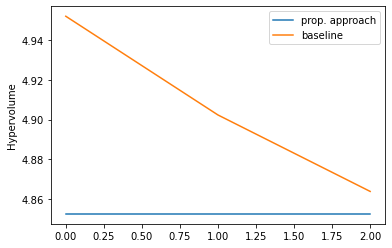

In [6]:
hv_approach = [history_approach[item]['hv'] for item in range(3)]
hv_baseline = [history_baseline[item]['hv'] for item in range(3)]

%matplotlib inline
matplotlib.pyplot.plot(hv_approach, label = 'prop. approach')
matplotlib.pyplot.plot(hv_baseline, label = 'baseline')
matplotlib.pyplot.legend()
matplotlib.pyplot.ylabel('Hypervolume')
matplotlib.pyplot.show()

The results obtained are not significant, we used too small populations and too small optimization time. <br>
If you have much time, you can experiment with larger sizes. You can also try to train surrogate models yourself.


Let's look at the solutions that we got

Text(0.5, 1.0, 'Proposed')

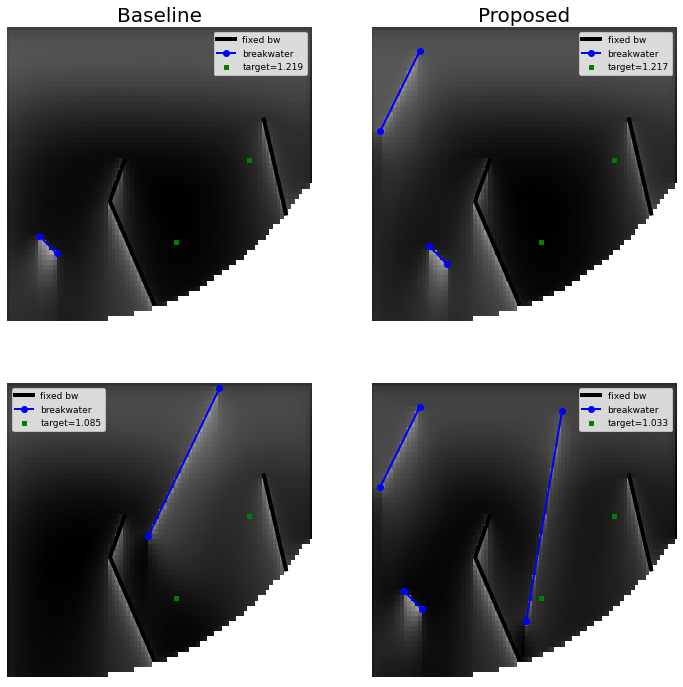

In [14]:
Z_baseline, sol_baseline = history_baseline[2]['Z_pop'], history_baseline[2]['pop']
Z_approach, sol_approach = history_approach[2]['Z_pop'], history_approach[2]['pop']

Z = Z_baseline + Z_approach
sol = sol_baseline + sol_approach
%matplotlib inline
fig, axs = matplotlib.pyplot.subplots(2, 2, figsize=(12,12))

plot_map(X, Y, Z[0], sol[0], axs[0,0])
plot_map(X, Y, Z[1], sol[1], axs[1,0])
plot_map(X, Y, Z[2], sol[2], axs[0,1])
plot_map(X, Y, Z[3], sol[3], axs[1,1])

axs[0, 0].set_title('Baseline', size = 20)
axs[0, 1].set_title('Proposed', size = 20)
